## 様々な打順で1試合で何得点得られるかSimulateする

In [1]:
import os
import pandas as pd
import numpy as np
import random

In [2]:
dirname = 'batting_average_data'

In [3]:
class Player:
    def __init__(self, name, ave_0out_csv, ave_1out_csv, ave_2out_csv):
        self.name = name
        self.ave = [pd.read_csv(os.path.join(dirname, ave_0out_csv), index_col=0), \
                        pd.read_csv(os.path.join(dirname, ave_1out_csv), index_col=0), \
                        pd.read_csv(os.path.join(dirname, ave_2out_csv), index_col=0)]
        
    def batting(self, out, runner, verbose):
        action = self.get_action(out, runner)
        if verbose:
            print(f'player: {self.name} action: {action}')
        
        return self.get_result(out, runner, action)
    
    def get_action(self, out, runner):
        table = self.ave[out]
        average = table[str(runner)]
        action = np.random.choice(list(average.index), p=list(average))
        
        return action
    
    def get_result(self, out, runner, action):
        # ランナーの移動はビット演算で表現する。3つのbitで、それぞれの塁にランナーがいたら1がたつ。
        # ヒットの場合は左に1シフト(あるいは2シフト)して1塁ビットに1をたてる。
        # 2塁打の場合には左に2シフト(あるいは3シフト)して2塁ビットに1をたてる。
        # 3塁打の場合には左に3シフトして3塁ビットに1をたてる。
        # ホームランの場合には左に4シフトして第4ビットに1をたてる。
        # 上記操作後に第4ビット以上に1がたっている数が得点。
        # 犠打の場合は左に1シフトしてアウトを1増やす。
        # アウトの場合はアウトを1増やす。

        if action == 'out':
            out += 1
        elif action == 'sacrifice':
            runner = runner << 1
            out += 1            
        elif action == 'single':
            if random.random() > 0.5:
                runner = runner << 1
            else:
                runner = runner << 2
            runner = runner | 0b0001
        elif action == 'double':
            if random.random() > 0.5:
                runner = runner << 2
            else:
                runner = runner << 3                
            runner = runner | 0b0010
        elif action == 'tripple':
            runner = runner << 3
            runner = runner | 0b0100
        elif action == 'homerun':
            runner = runner << 4
            runner = runner | 0b1000

        run, runner = self.get_score(runner)
        
        return out, runner, run
    
    def get_score(self, runner):
        run = bin(runner & 0b1111000).count('1')
        runner = runner & 0b111
        
        return run, runner

In [4]:
class Team:
    def __init__(self, player_list, order, verbose=False):
        self.player_list = player_list
        self.order = order
        self.n_inning = 9
        self.score = 0
        self.next_batter_id = 0
        self.verbose = verbose
        
    def inning(self):
        out = 0
        runner = 0
        
        while out < 3:
            player = self.player_list[self.order.index(self.next_batter_id)]
            out, runner, run = player.batting(out, runner, self.verbose)
            self.score += run
            self.next_batter_id = (self.next_batter_id + 1) % 9
            
    def play(self):
        for i in range(self.n_inning):                
            self.inning()
            if self.verbose:
                print(f'inning: {i+1} score:{self.score}\n')
            
        return self.score
    
    def reset(self):
        self.score = 0
        self.next_batter_id = 0

In [5]:
def get_random_order(n=9):
    base_list = [i for i in range(n)]
    random_list = random.sample(base_list, len(base_list))
    
    return random_list

In [ ]:
# player_listとorderから打順を名前で復元
def get_name_order(player_list, order):
    name_list = [player.name for player in player_list]
    player_in_order = []
    for i in range(len(order)):
        player_in_order.append(name_list[order.index(i)])
        
    return player_in_order

### 1試合ずつsimulate

#### playerの特性を記入したcsvを使ってインスタンス作成

In [6]:
Leadoff = Player('Leadoff', 'Leadoff - 0.csv', 'Leadoff - 1.csv', 'Leadoff - 2.csv')
Kawai = Player('Kawai', 'Kawai - 0.csv', 'Kawai - 1.csv', 'Kawai - 2.csv')
Ichiro = Player('Ichiro', 'Ichiro - 0.csv', 'Ichiro - 1.csv', 'Ichiro - 2.csv')
Bass = Player('Bass', 'Bass - 0.csv', 'Bass - 1.csv', 'Bass - 2.csv')
Komada = Player('Komada', 'Komada - 0.csv', 'Komada - 1.csv', 'Komada - 2.csv')
Tatsunami = Player('Tatsunami', 'Tatsunami - 0.csv', 'Tatsunami - 1.csv', 'Tatsunami - 2.csv')
Lance = Player('Lance', 'Lance - 0.csv', 'Lance - 1.csv', 'Lance - 2.csv')
Pitcher = Player('Pitcher', 'Pitcher - 0.csv', 'Pitcher - 1.csv', 'Pitcher - 2.csv')
Joker = Player('Joker', 'Joker - 0.csv', 'Joker - 1.csv', 'Joker - 2.csv')

player_list = [Leadoff, Kawai, Ichiro, Bass, Komada, Tatsunami, Lance, Pitcher, Joker]

#### ランダムオーダー作成

In [7]:
order = get_random_order()

#### 1試合をsimulateしてスコアを計算

In [66]:
team = Team(player_list, order, verbose=True)
score = team.play()

print(f'score:{score}')
team.reset()

player: Joker action: out
player: Leadoff action: out
player: Lance action: out
inning: 1 score:0

player: Tatsunami action: out
player: Pitcher action: single
player: Kawai action: out
player: Ichiro action: out
inning: 2 score:0

player: Bass action: out
player: Komada action: out
player: Joker action: out
inning: 3 score:0

player: Leadoff action: out
player: Lance action: out
player: Tatsunami action: out
inning: 4 score:0

player: Pitcher action: single
player: Kawai action: out
player: Ichiro action: single
player: Bass action: single
player: Komada action: out
player: Joker action: out
inning: 5 score:1

player: Leadoff action: out
player: Lance action: out
player: Tatsunami action: out
inning: 6 score:1

player: Pitcher action: out
player: Kawai action: out
player: Ichiro action: out
inning: 7 score:1

player: Bass action: single
player: Komada action: single
player: Joker action: out
player: Leadoff action: out
player: Lance action: out
inning: 8 score:1

player: Tatsunami act

### すべてのオーダーに対して100試合ずつsimulateしてスコアを記録

In [35]:
#時間がかかるので、ここでは最初が0番のケースだけに絞る

import itertools
from tqdm import tqdm

n_games = 100
base_order = [i for i in range(9)]

record_0 = pd.DataFrame()

for order_id, order in enumerate(tqdm(itertools.permutations(base_order))): 
    if order[0] == 0:
        scores = []
        for i in range(n_games):
            team = Team(player_list, order, verbose=False)
            score = team.play()
            scores.append(score)
    
        record_0[str(order_id)] = scores
        record_0[str(order_id)] = record_0[str(order_id)].astype('int8')
    
record_0.to_csv('record_0.csv')

362880it [2:24:04, 41.98it/s]


### orderの保存

In [73]:
import pickle 

order_dict = {}
for order_id, order in enumerate(tqdm(itertools.permutations(base_order))): 
    order_dict[order_id] = order
    
with open('order_dict.pickle', 'wb') as f:
    pickle.dump(order_dict, f)

362880it [00:00, 1223528.47it/s]


### 結果のLoad

In [39]:
import pandas as pd

record_0 = pd.read_csv('record_0.csv', index_col=0)

### orderのLoad

In [32]:
import pickle

with open('order_dict.pickle', 'rb') as f:
    order_dict = pickle.load(f)

### スコアの分析

#### 平均値

In [41]:
mean = record_0.mean()

##### 最小値、自分が選んだオーダー, 最大値の平均値

In [42]:
min(mean), mean[0], max(mean)

(1.8, 2.97, 3.98)

##### 最も平均が低かったorder

In [53]:
min_mean_order = order_dict[int(mean.idxmin())]
print(get_name_order(player_list, min_mean_order))

['Leadoff', 'Komada', 'Ichiro', 'Tatsunami', 'Pitcher', 'Lance', 'Kawai', 'Joker', 'Bass']


<AxesSubplot:>

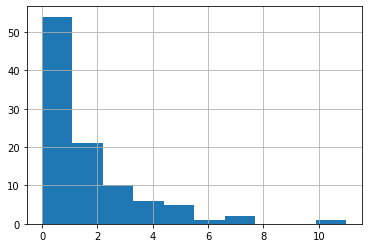

In [44]:
%matplotlib inline 

record_0[mean.idxmin()].hist()

##### 最も平均が高かったorder

In [52]:
max_mean_order = order_dict[int(mean.idxmax())]
print(get_name_order(player_list, max_mean_order))

['Leadoff', 'Ichiro', 'Kawai', 'Joker', 'Tatsunami', 'Bass', 'Komada', 'Pitcher', 'Lance']


<AxesSubplot:>

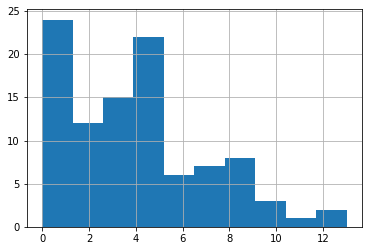

In [46]:
record_0[mean.idxmax()].hist()

##### 自分が考える最高のオーダー

In [51]:
my_order = order_dict[0]
print(get_name_order(player_list, my_order))

['Leadoff', 'Kawai', 'Ichiro', 'Bass', 'Komada', 'Tatsunami', 'Lance', 'Pitcher', 'Joker']


##### 3つのオーダーのスコア分布比較

<AxesSubplot:ylabel='Frequency'>

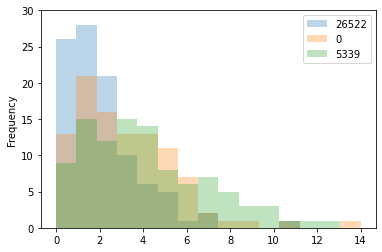

In [110]:
record_0[[mean.idxmin(), '0', mean.idxmax()]].plot.hist(ylim=(0, 30), alpha=0.3, bins=15)

##### 自分のオーダーと平均が最高のオーダーのスコア分布の比較

<AxesSubplot:ylabel='Frequency'>

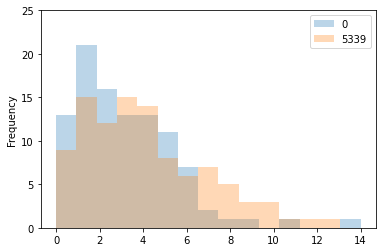

In [123]:
record_0[['0', mean.idxmax()]].plot.hist(ylim=(0, 25), alpha=0.3, bins=15)

#### 標準偏差

In [55]:
std = record_0.std()

In [56]:
min(std), std[0], max(std)

(1.5382004440451205, 2.4922303507525383, 3.267393240162345)

##### 標準偏差最小

In [59]:
min_std_order = order_dict[int(std.idxmin())]
print(get_name_order(player_list, min_std_order))

['Leadoff', 'Pitcher', 'Lance', 'Bass', 'Tatsunami', 'Kawai', 'Joker', 'Ichiro', 'Komada']


In [61]:
#平均値
mean[int(std.idxmin())]

2.24

<AxesSubplot:>

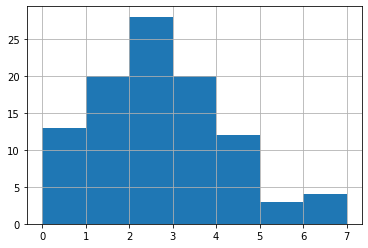

In [113]:
record_0[std.idxmin()].hist(bins=7)

##### 標準偏差最大

In [62]:
max_std_order = order_dict[int(std.idxmin())]
print(get_name_order(player_list, max_std_order))

['Leadoff', 'Pitcher', 'Lance', 'Bass', 'Tatsunami', 'Kawai', 'Joker', 'Ichiro', 'Komada']


In [63]:
#平均値
mean[int(std.idxmax())]

3.53

<AxesSubplot:>

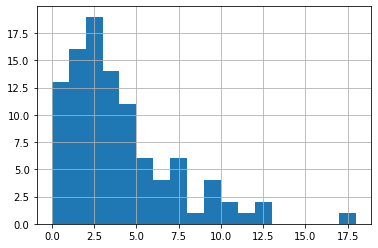

In [64]:
record_0[std.idxmax()].hist(bins=18)

##### 各オーダーでスコア分布の比較

<AxesSubplot:ylabel='Frequency'>

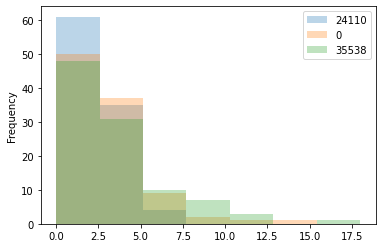

In [119]:
record_0[[std.idxmin(), '0', std.idxmax()]].plot.hist(alpha=0.3, bins=7)